# DE Portoflio 7: Evaluation of Tree Based Classifier Models

This model uses the GTD (Global Terrorism Dataset) data. The dataset includes records of terrorist incidents and events starting 1970, including details such as targets, weapons, terrorist organizations or number of kills. The goal is to classify attacks and predict the type of occuring attacks based on relevant features. The notebook evaluates 4 models (CART Decision Tree, Random Forest, AdaBoost and XGBoost) to understand the model that is a better fit to classify attacks. This notebook replicates the evaluation methods for logistic regression by utilizing K folds to validate and evaluate models. The evaluation metrics used here are accuracy, recall, F1 score, etc., as the main goal of the model is determinisc prediction.

Dataset Source: [https://www.start.umd.edu/gtd/](https://www.start.umd.edu/gtd/)

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from scipy import stats
from scipy.stats import ks_2samp
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import random


### Load and Prepare Data

In [2]:
#Load GTD data and apply filters
df=pd.read_csv('Data_All.csv')
display(df)

C:\Users\maria\AppData\Local\Temp\ipykernel_14540\1623173151.py:2: DtypeWarning: Columns (4,31,33,37,54,61,62,63,76,79,90,92,94,96,114,115,121,135) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Data_All.csv')


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,1_txt
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214661,202106300023,2021,6,30,NaN,0,NaN,4,Afghanistan,6,...,"""Gunmen blow up power pylon in Parwan,"" Afghan...","""Provinces hit by blackout after power pylon d...",NaN,START Primary Collection,-9,-9,0,-9,NaN,Electricity
214662,202106300029,2021,6,30,06/30/2021,0,NaN,138,Myanmar,5,...,"""Spring Revolution Daily News for 16-30 June 2...",NaN,NaN,START Primary Collection,-9,-9,0,-9,NaN,Other Personnel
214663,202106300030,2021,6,30,NaN,1,2021-07-08,147,Nigeria,11,...,"""Boko Haram Releases Abducted Catholic Priest ...","""Kidnapped Maiduguri Catholic Priest regains f...","""ISWAP-Boko Haram Abduct Catholic Priest In Bo...",START Primary Collection,0,0,0,0,NaN,Religious Figure
214664,202106300038,2021,6,30,NaN,0,NaN,45,Colombia,3,...,"""Two dead and one wounded after clashes betwee...",NaN,NaN,START Primary Collection,0,0,0,0,NaN,NaN


#### Features selected
1. region_txt: categorical value for regions where attacks took place
    - For this model we focus on Europe and North America
2. targtype1_txt: (categorical value) explaining the types of targets attacked by the terrorist organisation

3. weaptype1_txt: categorical value for type of weapons sued during the attack

4. property: If a property was attacked during the terrorist incident  (1 = Yes; 0 = No)

5. crit1: binary value explaining whether the attack had a political, social or economic goal (1=Yes; 0=No)

6. crit2: binary value representing whether the attack ahd the intention to coerce or intimidate the public (1=Yes; 0=No)

7. attacktype1_txt: categorical value defining the attack type of the event

8. victims: numerical value representing the number of victims

In [3]:
#Select relevant features
features=['region_txt', 'crit1', 'crit2', 'attacktype1_txt',
          'targtype1_txt', 'weaptype1_txt', 'nkill', 'nwound', 'property']
df=df[features]

#Replace unknown, other and -9 values with Nan and remove them
values_to_replace = ['Unknown', 'Other', -9, -99]
df.replace(values_to_replace, np.nan, inplace=True)
df=df.dropna()

#Calculate total number of victims from interaction of killed and wounded
df['victims_total']=df['nkill']+df['nwound']

#CODE ADDED FOR RESUBMISSION: Sample dataframe to reduce the number of values in order to make code execute faster 
#This was done because the dataframe has a large number of values which increased execution time
#df = df.sample(frac=0.4, random_state=42)
display(df)



,region_txt,crit1,crit2,attacktype1_txt,targtype1_txt,weaptype1_txt,nkill,nwound,property,victims_total
5,North America,1,1,Armed Assault,Police,Firearms,0.0,0.0,1.0,0.0
6,South America,1,1,Assassination,Police,Firearms,0.0,0.0,0.0,0.0
7,North America,1,1,Bombing/Explosion,Utilities,Explosives,0.0,0.0,1.0,0.0
8,North America,1,1,Facility/Infrastructure Attack,Military,Incendiary,0.0,0.0,1.0,0.0
9,North America,1,1,Facility/Infrastructure Attack,Government (General),Incendiary,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
214658,Middle East & North Africa,1,1,Bombing/Explosion,Private Citizens & Property,Explosives,0.0,0.0,0.0,0.0
214659,Sub-Saharan Africa,1,1,Armed Assault,Government (Diplomatic),Firearms,7.0,0.0,0.0,7.0
214661,South Asia,1,1,Bombing/Explosion,Utilities,Explosives,0.0,0.0,1.0,0.0
214663,Sub-Saharan Africa,1,1,Hostage Taking (Kidnapping),Religious Figures/Institutions,Firearms,0.0,0.0,0.0,0.0


In [4]:
#Encode target type
target_dummies=pd.get_dummies(df['targtype1_txt'], drop_first=True)
targets = target_dummies.astype(int)

#Encode regions
region_dummies=pd.get_dummies(df['region_txt'], drop_first=True)
region = region_dummies.astype(int)

#Encode weapon
weapon_dummies=pd.get_dummies(df['weaptype1_txt'], drop_first=True)
weapons=weapon_dummies.astype(int)

#Ensure other values are numerical
ideology=df['crit1'].astype(int)
property=df['property'].astype(int)
coercion=df['crit2'].astype(int)
victims=df['victims_total'].astype(int)


In [5]:
#Label attacks - need to be integers for models

attacks = {'Armed Assault':0, 'Assassination': 1, 'Bombing/Explosion': 2, 'Facility/Infrastructure Attack': 3, 'Hijacking':4, 'Hostage Taking (Barricade Incident)':5, 'Hostage Taking (Kidnapping)':6, 'Unarmed Assault':7}
df['attacktype1_txt'] = df['attacktype1_txt'].replace(attacks)


### Split Data and Fit Models

In [6]:
#Define Y -- outcome variable
Y_rf=df['attacktype1_txt']

#Define x
X_rf= pd.concat([victims, targets, region, property, ideology, coercion, weapons], axis=1)

In [7]:
#Define models used for testing
models_test = {  
    'CART Decsion Tree': DecisionTreeClassifier(random_state=42, max_depth=3),                                                                     
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=3),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=42),
    'XGBoost':XGBClassifier(max_depth=3, n_estimators=100, random_state=42, objective='multi:softprob')
}

In [8]:
#Split data into test set and validation set (proportion used is 25-test / 75-validation)
YX =  pd.concat([Y_rf,X_rf],axis = 1)

#Extract 25% of the dataset using integer division to get result as an int
samples = YX.shape[0]* 25 // 100

#Create list of all row IDs assuming they start at 0
row_id = list(range(YX.shape[0]))

#Select 25% of IDs randomly
row_ids = random.sample(row_id, samples)

#Create test set
YX_test = YX.iloc[YX.index.isin(row_ids)] # the randomly chosen 25% goes to test set

#Create validation set
YX_validation = YX.iloc[~YX.index.isin(row_ids)] # the remaining 75% is  validation set


In [9]:
y = YX_validation['attacktype1_txt'] # Define y
YX_validation=YX_validation.drop(columns=['attacktype1_txt']) #Define X

#Define K
K = 5

#Set up the KFold validation
kf = KFold(n_splits=K, shuffle=True)

#Set up empty dictionary to store calcualted scores
scores = {key: [] for key in models_test}

precision_scores = {key: [] for key in models_test} #dictionary for precision per model
recall_scores = {key: [] for key in models_test} #dictionary for recall per model
f1_scores = {key: [] for key in models_test} #dictionary for F1 per model
acc = {key: [] for key in models_test} #dictionary for accuracy per model
balanced_acc = {key: [] for key in models_test} #dictionary for balanced acc per model

#Iterate through models and calcualte evaluation scores
for name, model_type in models_test.items():
    for train_index, test_index in kf.split(YX_validation):
        
        #Split data based on K folds number
        X_train, X_test = YX_validation.iloc[train_index], YX_validation.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        #Fit all models
        model = model_type.fit(X_train, y_train)
                
        #Generate label classification
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) #Generate probabilities of labels to be correctly assigned

        #Calculate scores
        acc_score = accuracy_score(y_test, y_pred) #accuracy
        acc[name].append(acc_score) #append to dictionary
        
        bal_acc_score = balanced_accuracy_score(y_test, y_pred) #balanced accuracy
        balanced_acc[name].append(bal_acc_score) 
        
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1) #precision
        #using weighted average accounts for the imbalance of the data
        precision_scores[name].append(precision)

        recall = recall_score(y_test, y_pred, average='weighted') #recall
        recall_scores[name].append(recall)

        f1 = f1_score(y_test, y_pred, average='weighted') #F1 score
        f1_scores[name].append(f1)
    
#Calculate average scores for evaluation metrics per model
results = []
for name in models_test.keys():
    average_bal_acc_score = np.mean(balanced_acc[name]) # balanced accuracy
    average_acc_score = np.mean(acc[name]) # average accuracy
    average_precision = np.mean(precision_scores[name]) #precison
    average_recall = np.mean(recall_scores[name]) #recall
    average_f1 = np.mean(f1_scores[name]) #F1
    results.append({
        'Model': name,
        'Average Accuracy': average_acc_score,
        'Average Balanced Accuracy': average_bal_acc_score,
        'Average F1': average_f1,
        'Average Precision Score': average_precision,
        'Average Recall': average_recall,
    })

#Put results in a DataFrame and print
results_df = pd.DataFrame(results)
display(results_df)


,Model,Average Accuracy,Average Balanced Accuracy,Average F1,Average Precision Score,Average Recall
0,CART Decsion Tree,0.785875,0.341026,0.719384,0.844548,0.785875
1,Random Forest,0.783363,0.342772,0.715407,0.836815,0.783363
2,AdaBoost,0.797733,0.364411,0.757396,0.782133,0.797733
3,XGBoost,0.837883,0.562340,0.826485,0.826981,0.837883


As mentioned at the beginning of the notebook, this evaluation uses Accuracy, F1 score, Precision and Recall due to the prediction task being the classification of multiple categories and goal of model being to determine classes. Other scores such as Brier score or AIC which are often used for classification or logistic regression do not work here due to the task of the model. When comparing all 4 models, the XGBoost model appears to be the best performing model, so we will further evaluate it on the full validation set.

#### Fit Model on Full Set

In [10]:
#Define and fit model
XG=XGBClassifier(max_depth=3, n_estimators=100, random_state=42, objective='multi:softprob')
model = XG.fit(X_train, y_train)

#Generate predictions
X_test = YX_validation
y_test = y
y_pred_test = model.predict(X_test)
y_proba = model.predict_proba(X_test)

#### Evaluate Model

In [11]:
#Calculate evaluation metrics
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted', zero_division=1)
recall_test = recall_score(y_test, y_pred_test, average='weighted')
bal_acc_score = balanced_accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average='weighted')

#Print scores
print(f"Accuracy: {accuracy_test}")
print(f'Balanced accuracy: {bal_acc_score}')
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")


Accuracy: 0.8393091096038077
Balanced accuracy: 0.5704443747694619
Precision: 0.828636219948547
Recall: 0.8393091096038077
F1 Score: 0.8280765723762187


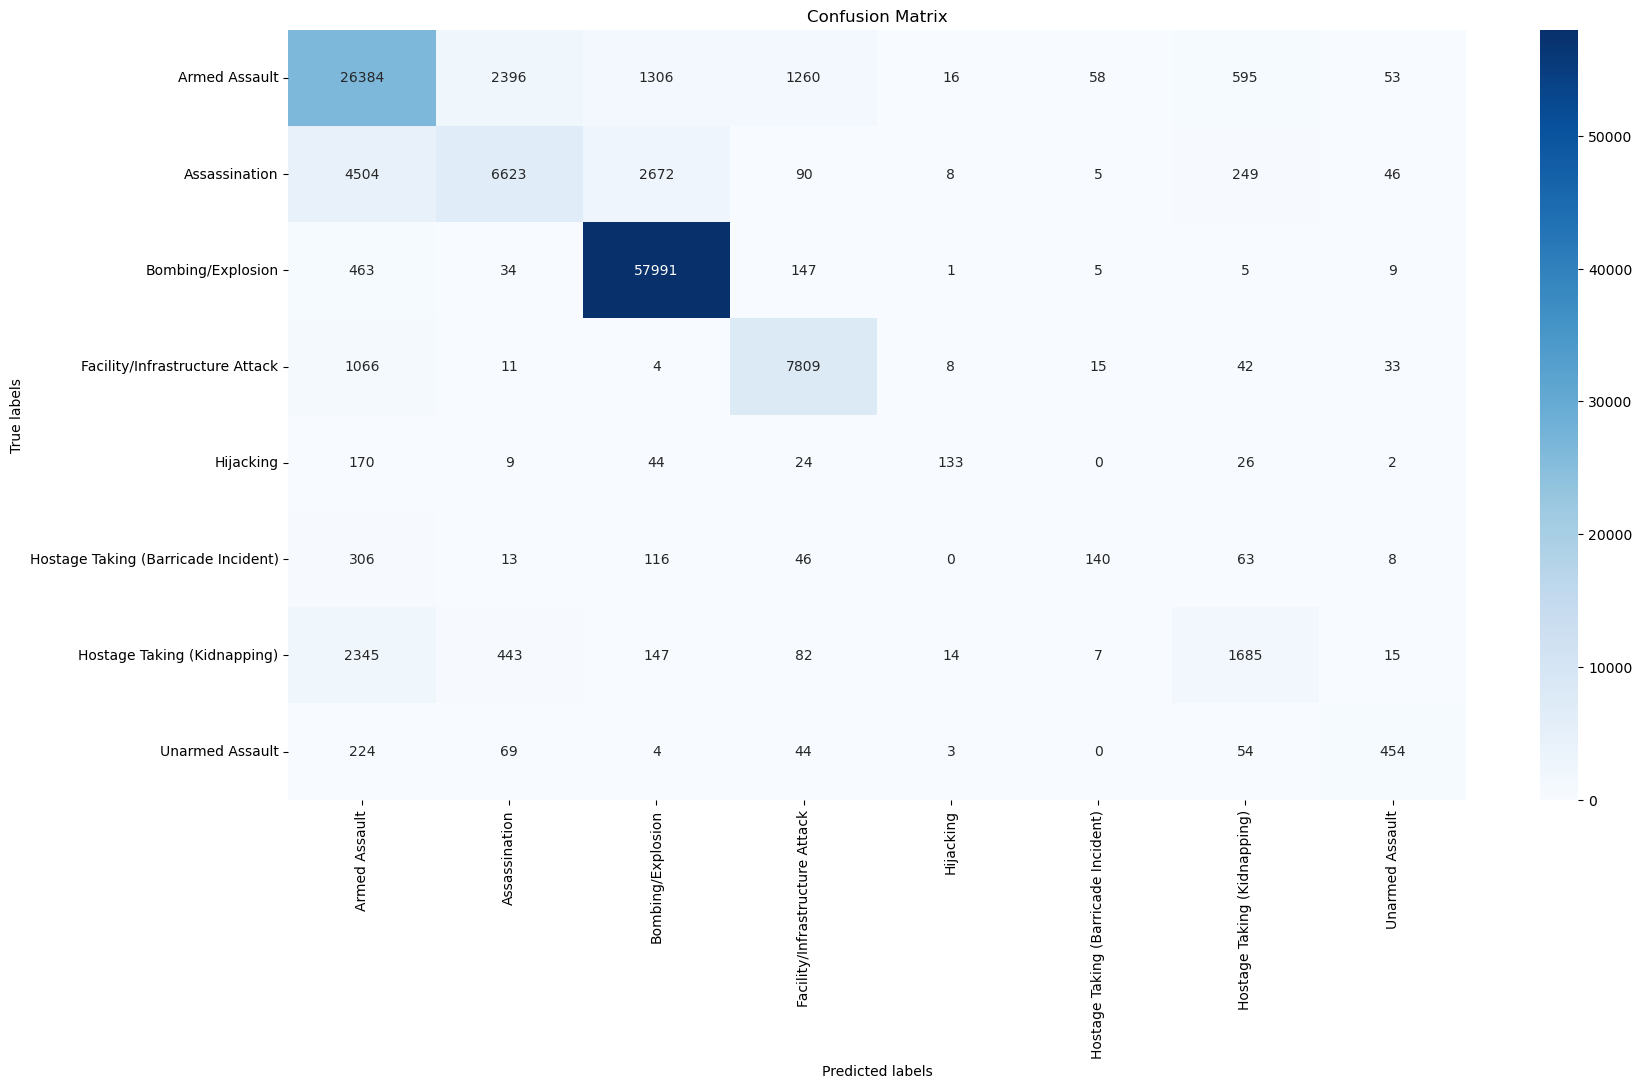

In [12]:
#Calcualte and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

#Define labels
attacks=['Armed Assault', 'Assassination', 'Bombing/Explosion', 'Facility/Infrastructure Attack',  'Hijacking', 'Hostage Taking (Barricade Incident)', 'Hostage Taking (Kidnapping)', 'Unarmed Assault']
df['attacktype1_txt'] = df['attacktype1_txt'].replace(attacks)

#Plot
plt.figure(figsize=(19, 10))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=attacks, yticklabels=attacks)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


#### Analyzing variability of evaluation metrics 

To further analyze the performance of the model, this notebook checks the range of evaluation metric scores as a result of the k fold validation. Using bootstraming to generate multiple subsets, we can see how the model performs across different samples and visualize the distribution of evaluation scores. 

In [13]:
import numpy as np
import matplotlib.pyplot as plt

#Specify chosen model
model = 'XGBoost'

#Extract scores of chosen model from dictionaries created during the K Fold process
accuracies = acc[model]
precisions=precision_scores[model]
balanced_accuracy=balanced_acc[model]
F1=f1_scores[model]
recall=recall_scores[model]

#Select the number of scores we generate
num_samples = 1000

#Apply boostrapping to generate samples
boot_acc = []
boot_prec=[]
boot_f1=[]
boot_bal=[]
boot_recall=[]
for x in range(num_samples):
    #Apply sample remplacements to all scores
    accuracy_sample = np.random.choice(accuracies, size=len(accuracies), replace=True)
    precision_sample=np.random.choice(precisions, size=len(precisions), replace=True)
    balanced_sample=np.random.choice(balanced_accuracy, size=len(balanced_accuracy), replace=True)
    f1_sample=np.random.choice(F1, size=len(f1_scores), replace=True)
    recall_sample=np.random.choice(recall, size=len(recall), replace=True)

    #Calcualte evaluation metrics for each sample generated
    accuracy = np.mean(accuracy_sample)
    boot_acc.append(accuracy)

    precision = np.mean(precision_sample)
    boot_prec.append(precision)

    balanced = np.mean(balanced_sample)
    boot_bal.append(balanced)

    f_one = np.mean(f1_sample)
    boot_f1.append(f_one)

    rec = np.mean(recall_sample)
    boot_recall.append(rec)


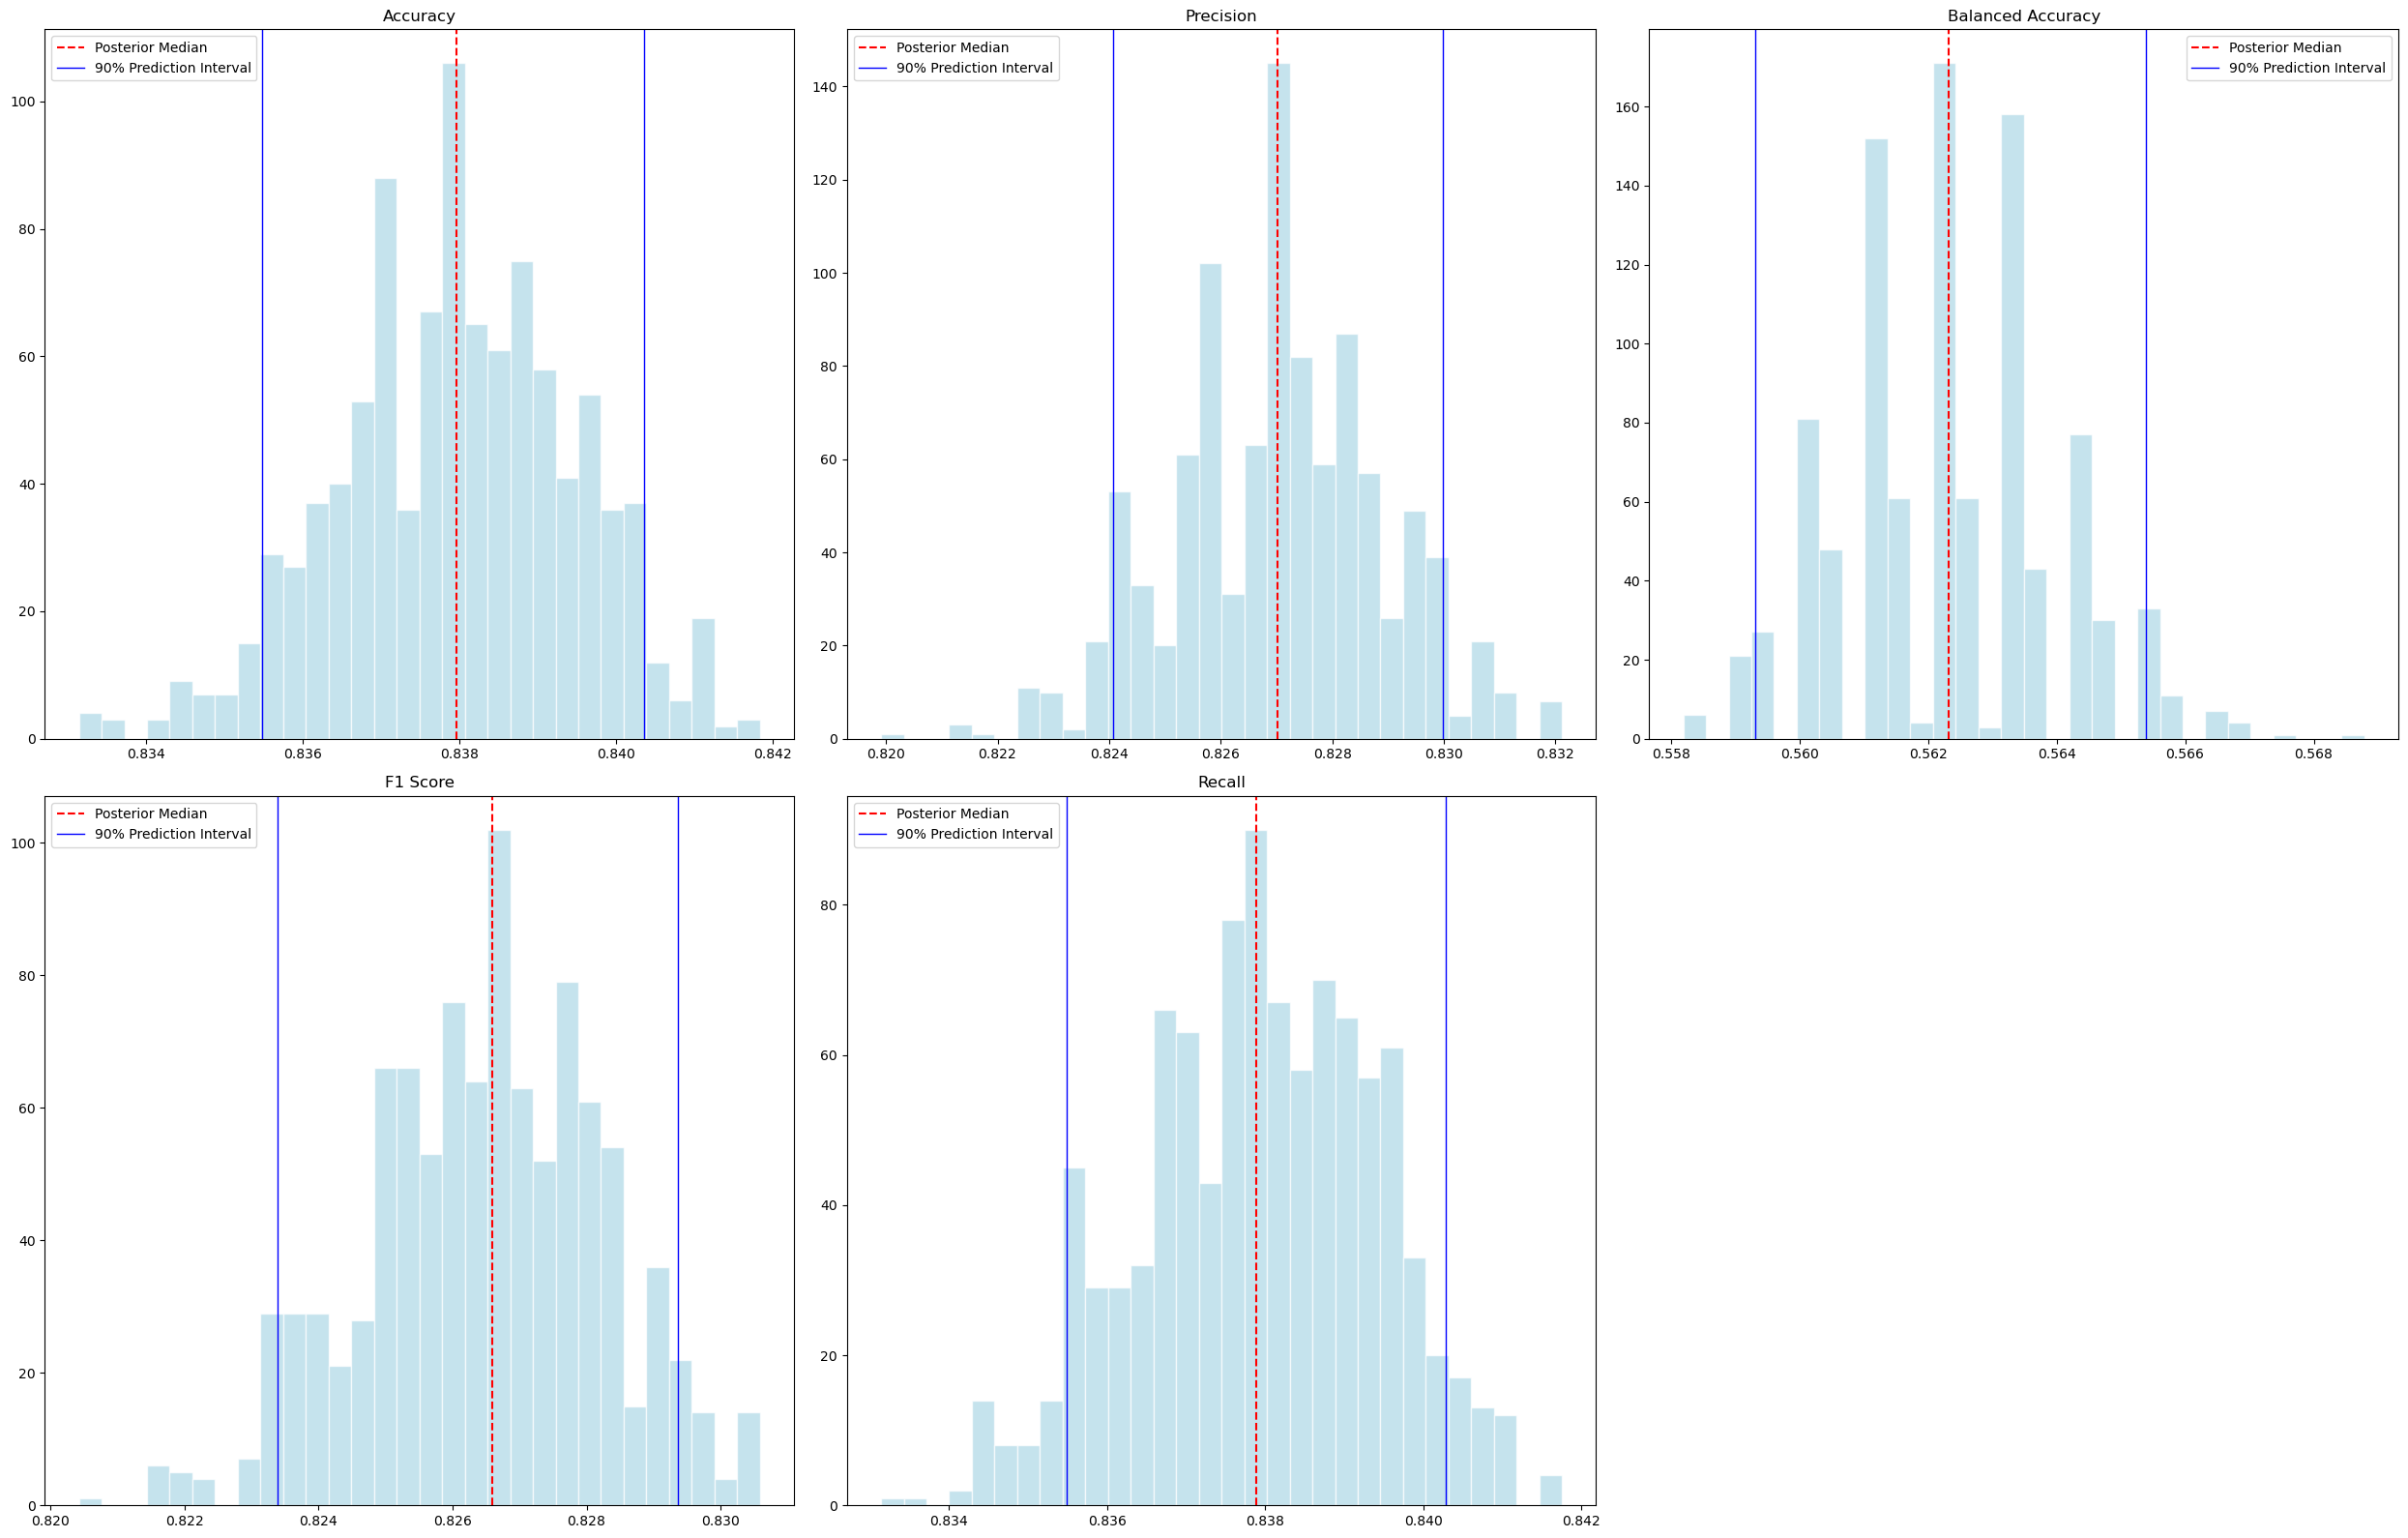

In [14]:
#Plot distributions

def metrics_plots (ax, metric, boot_val): #Initialize function to plot scores and indicate median, lower and upper bound for confidence interval
    median=np.median(boot_val) # median
    l_bound=np.percentile(boot_val, 5) # lower bound
    u_bound=np.percentile(boot_val, 95) # upper bound

    ax.hist(boot_val, bins=30, color='lightblue', edgecolor='white', alpha=0.7)
    ax.axvline(x=median, color='red', linestyle='--', label='Posterior Median')
    ax.axvline(x=l_bound, color='blue', linestyle='-', linewidth=1, label='90% Prediction Interval')
    ax.axvline(x=u_bound, color='blue', linestyle='-', linewidth=1)
    ax.set_title(metric)
    ax.legend()

fig, axes = plt.subplots(2, 3, figsize=(25, 16))

#Plot accuracy 
metrics_plots(axes[0, 0], 'Accuracy', boot_acc)

#Plot precision 
metrics_plots(axes[0, 1], 'Precision', boot_prec)

#Plot balanced accuracy 
metrics_plots(axes[0, 2], 'Balanced Accuracy', boot_bal)

#Plot F1 score 
metrics_plots(axes[1, 0], 'F1 Score', boot_f1)

#Plot recall
metrics_plots(axes[1, 1], 'Recall', boot_recall)

# Hide empty plots
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

#### Assessing reliability of predictions

This is an additional step I wanted to take in order to have an additional analysis of the model. When fitting the model and generating predictions, I also generated predicted probabilities of each sample to be classified as a certain category. While the main focus of the model and its evaluation is on ability to classify and predict attacks based on given features, I also wanted to take a look at how confident the model is in the classification process.

In [15]:
from sklearn.metrics import brier_score_loss
num_classes = len(y_test.unique())
brier_scores = []
for i in range(num_classes):
    #Extract predicted probabilities for each class
    y_proba_class_i = y_proba[:, i]
    #Compute Brier score for each class
    brier_score_class_i = brier_score_loss(y_test == i, y_proba_class_i)
    brier_scores.append(brier_score_class_i)

print("Brier Scores for each class:", brier_scores)


Brier Scores for each class: [0.08458682924260767, 0.06550964496546088, 0.0352170926045247, 0.01753590893203318, 0.0023856995088697578, 0.004843369811690932, 0.027377408599617056, 0.003549912484739952]


In [16]:
classes = y_test.unique()
n_classes=len(classes)

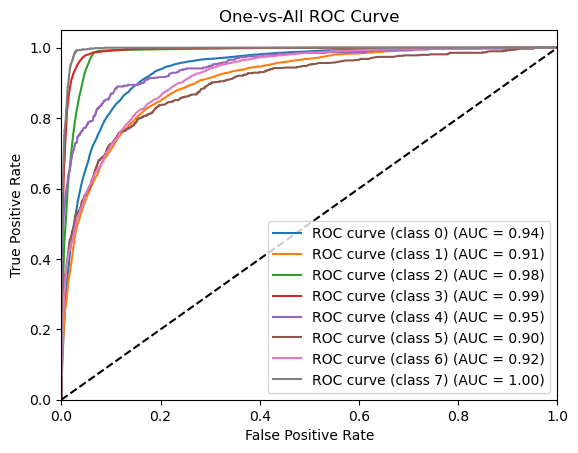

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class %d) (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-All ROC Curve')
plt.legend(loc="lower right")
plt.show()



Both Brier Score and ROC Curve show that the high probabilities and certainity regarding the classification of features to the right class. With these evaluation metrics being very close to perfect values, concerns are raised regarding potential overfititng. This can be caused because of the imbalances in the data as well as labeling or encoding techniques. While these scores are important to consider the performance of the model, I assigned more importance to evaluation scores used for determinisc probability as that it the prediction task goal.